In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
import line_profiler as lp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *
from analysis import *
from datagen2D import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on CPU


c:\Users\matti\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on CPU


## Dataset Testing

In [2]:
# lp profile of smooth_wandering_2D_complex_bound
# %load_ext line_profiler
# %lprun -f smooth_wandering_2D_complex_bound smooth_wandering_2D_complex_bound(64,200,bound=0.5,v_sigma=0.02,d_sigma=0.1)

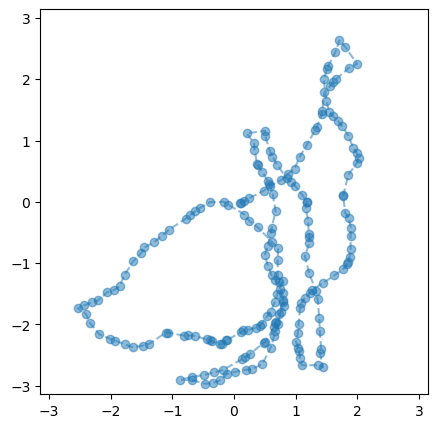

In [3]:
data,labels = smooth_wandering_2D_complex_bound(64,200,bound=0.5,v_sigma=0.02,d_sigma=0.1)

# Plot positions from labels
plt.figure(figsize=(5,5))
n = 0
plt.plot(labels[n,:,0],labels[n,:,1],"--o",alpha=0.5)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.show()

In [4]:
# data,labels = rat_box(1000,10)

# # data, labels = smooth_wandering_2D_bing(n_data=100,t_steps=20,bound=0.5)
# x,y,vx,vy = random_walk(40)

# # Plot 2D wandering
# plt.figure(figsize=(5,5))
# plt.plot(x,y,'-o')
# plt.show()

## Model

In [5]:
hidden_size = 128
input_size = 1
nav_size = 1

model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)
# model1 = torch.compile(model1)

train = False

if train:
    _ = model1.train_gradual(epochs=10000)
    # model1.base_training_tsteps = 40
    # _ = model1.train(epochs=10000)
    model1.plot_losses(average=30)
else:
    # model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual+2000base.pt"))
    model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_10000gradual.pt",map_location=torch.device('cpu')))

# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

In [6]:
# model1.base_training_tsteps = 200
# _ = model1.train(epochs=1)
# model1.plot_losses(average=30)

In [7]:
# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_10000gradual+2000base.pt")

## Analysis

### Norm of activity per timestep

In [8]:
# htss = model1.hts.norm(dim=2)
# htss = htss.cpu().detach().numpy()
# plot_norm(htss,avg_only=False)

### Tuning curves

#### 1D

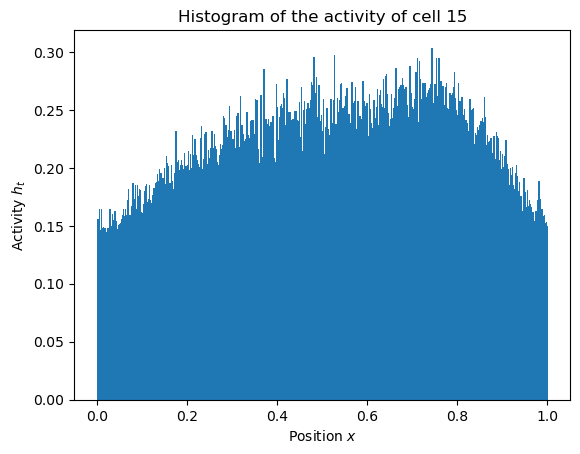

In [9]:
activity, bin_edges = tuning_curve(model1,bins=2000)
plot_tuning_curve(activity,bin_edges,15,spherical=False,linear=False,scale_to_one=True, plot_head_frac=1/10)

In [10]:
activity.shape
# bin_edges.shape

(128, 2000)

#### 2D

In [11]:
t_test = 40
test_batch_size = 5000
data, labels = smooth_wandering_2D_complex_bound(n_data=test_batch_size,t_steps=t_test,bound=0.5,v_sigma=0.02,d_sigma=0.1)

In [12]:
xdata = data[:,:,0]
ydata = data[:,:,1]
xlabels = labels[:,:,0]
ylabels = labels[:,:,1]

xactivity, xbin_edges = tuning_curve(model1,spherical_data=False,in_activity=(xdata,xlabels),bins=2000)
yactivity, ybin_edges = tuning_curve(model1,spherical_data=False,in_activity=(ydata,ylabels),bins=2000)

In [13]:
xbin_edges.shape

(2001,)

In [28]:
def plot_2D_tuning_curve(xactivity,yactivity,xbin_edges,ybin_edges,k_test,plot_head_frac=1/10,scale_to_one=False,linear=False):
    if scale_to_one:
        scaler = 1/(2*np.pi)
    else:
        scaler = 1

    xbin_edges = xbin_edges[:-1]*scaler
    ybin_edges = ybin_edges[:-1]*scaler
    bins = len(xbin_edges)

    n_cells = xactivity.shape[0]

    # # Combine x and y activity
    # xactivity_test = np.tile(xactivity[k_test,:],(bins,1))
    # yactivity_test = np.tile(yactivity[k_test,:],(bins,1))
    # activity = xactivity_test * yactivity_test.T

    # # Plot heat map of activity of cell k_test
    # plt.figure(figsize=(5,5))
    # plt.imshow(activity,extent=[xbin_edges[0],xbin_edges[-1],ybin_edges[0],ybin_edges[-1]],vmin=0,vmax=np.max(activity))
    # plt.colorbar()
    # plt.title("Heat map of the activity of cell "+str(k_test))
    # plt.xlabel(r"Position $x$")
    # plt.ylabel(r"Position $y$")
    # plt.show()

    if linear:
        fig, ax = plt.subplots(int(32*plot_head_frac),4)
        fig.set_size_inches(15, 80*plot_head_frac)
        fig.subplots_adjust(hspace=1,wspace=0.2)
        for k in tqdm(range(int(n_cells*plot_head_frac))):
            xactivity_k = np.tile(xactivity[k,:],(bins,1))
            yactivity_k = np.tile(yactivity[k,:],(bins,1))
            activity = xactivity_k * yactivity_k.T
            ax[k//4,k%4].imshow(activity,extent=[xbin_edges[0],xbin_edges[-1],ybin_edges[0],ybin_edges[-1]],vmin=0,vmax=np.max(activity))
            ax[k//4,k%4].set_title("Cell "+str(k))
            ax[k//4,k%4].set_xlabel(r"Position $x$")
            ax[k//4,k%4].set_ylabel(r"Position $y$")
        plt.show()


100%|██████████| 16/16 [00:00<00:00, 21.56it/s]


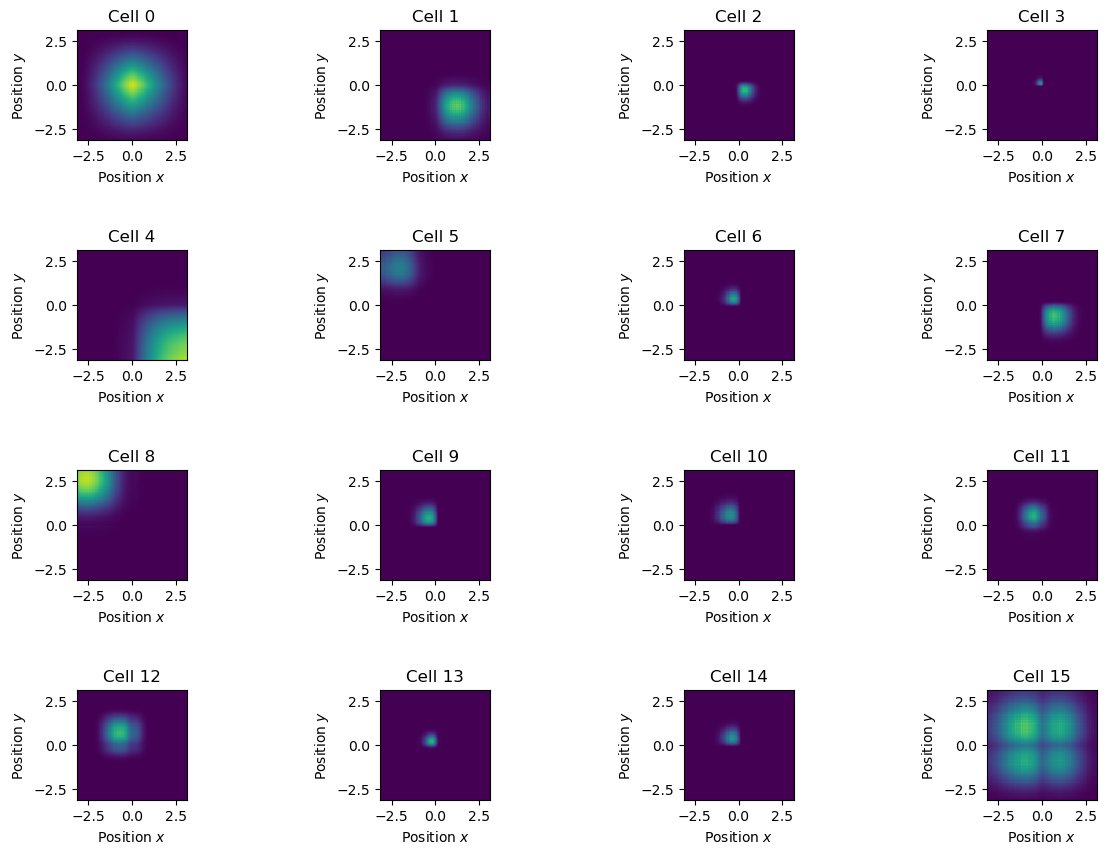

In [29]:
plot_2D_tuning_curve(xactivity,yactivity,xbin_edges,ybin_edges,k_test=3,plot_head_frac=1/8,scale_to_one=False,linear=True)

### Low dimensional representations

#### 1D

Explained variance for PCA with 2 components: 92.715 %


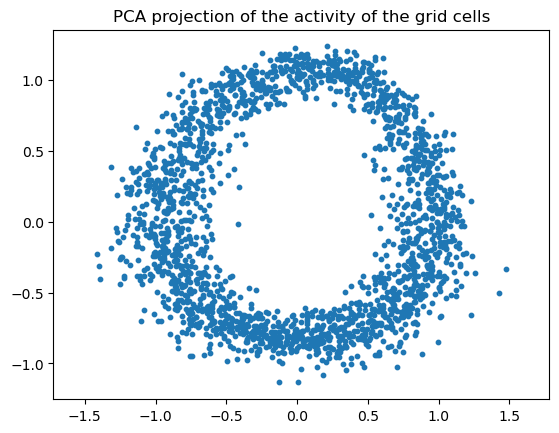

In [16]:
embedding, reducer = lowD_reduce(activity,if_pca=True,n_components=2,plot=True)

#### 2D

In [40]:
# xembedding, xreducer = lowD_reduce(xactivity,if_pca=True,n_components=2,plot=True)
# yembedding, yreducer = lowD_reduce(yactivity,if_pca=True,n_components=2,plot=True)

### Accuracy testing

#### 1D

In [18]:
angs, dy, err, y_hat, y = test_angle_inference(model1,reducer)


Mean error:  0.10888236035242091


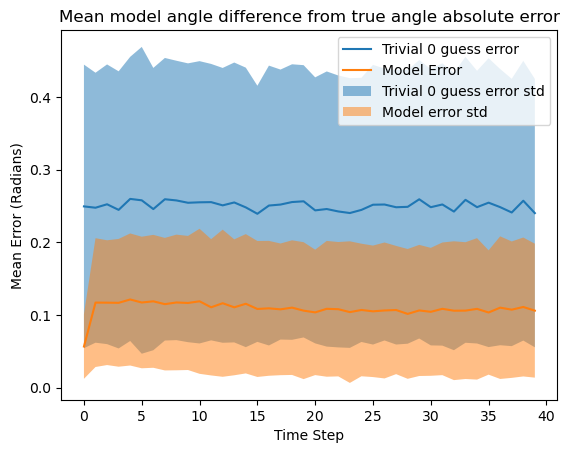

In [19]:
plot_accuracy(angs,dy,y_hat,y)

Mean error:  0.3350033209844893
Mean end error:  0.4693912843125366


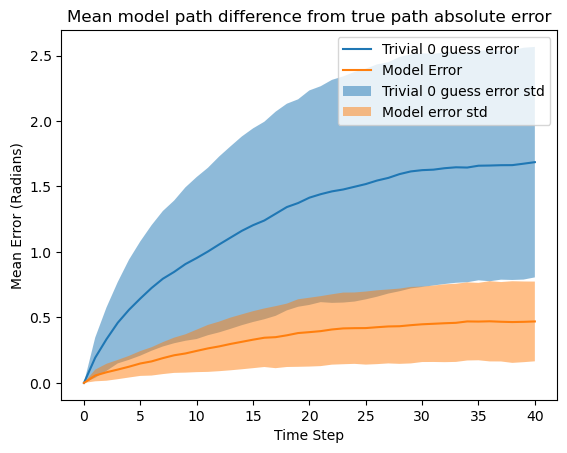

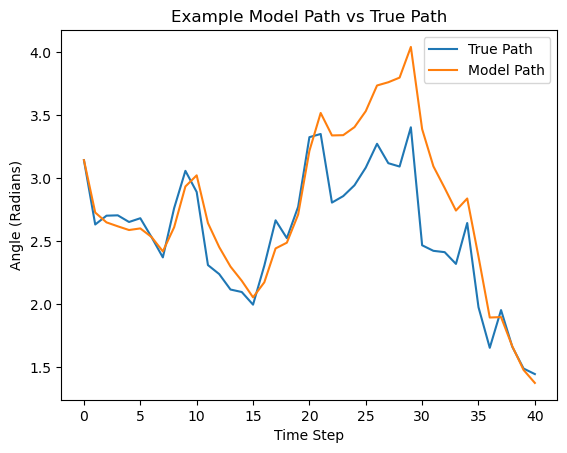

In [20]:
plot_path_accuracy(angs,y,example_path=1)

#### 2D

In [38]:
# call old y for theta (theoretical angles)
xangs, xdtheta, xerr, xhidden_state, xtheta = test_angle_inference(model1,reducer,in_activity=(xdata,xlabels),start=0)
yangs, ydtheta, yerr, yhidden_state, ytheta = test_angle_inference(model1,reducer,in_activity=(ydata,ylabels),start=0)

Mean error:  0.03845261057729908
Mean error:  0.03926236778094729


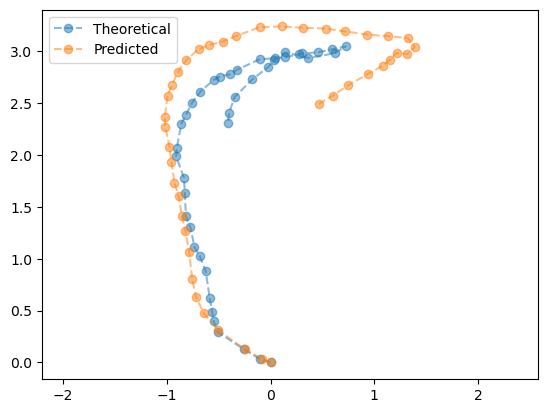

In [39]:
n = 14

plt.plot(xtheta[n,:],ytheta[n,:],'--o', alpha=0.5, label='Theoretical')

xpath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
ypath = np.zeros((xangs.shape[0],xangs.shape[1]+1))
xpath[:,0] = 0
ypath[:,0] = 0
for i in range(1,angs.shape[1]+1):
    xpath[:,i] = xpath[:,i-1] + xangs[:,i-1]
    ypath[:,i] = ypath[:,i-1] + yangs[:,i-1]

plt.plot(xpath[n,:],ypath[n,:],'--o', alpha=0.5, label='Predicted')
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.axis('equal')
plt.legend()
plt.show()